# Financial analytics of S&P 500 and the VIX

## Gathering the data

In [1]:
from alpha_vantage.timeseries import TimeSeries #Python module to get stock data from the Alpha Vantage API

# Update your Alpha Vantage API key here...
ALPHA_VANTAGE_API_KEY = 'PZ2ISG9CYY379KLI'

ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas') #Generate Alpha Vantage time series object
df_spx_data, meta_data = ts.get_daily_adjusted(
    symbol='^GSPC', outputsize='full') #Retrieve the data

In [2]:
df_vix_data, meta_data = ts.get_daily_adjusted(
    symbol='^VIX', outputsize='full') #Retrieve the data

In [3]:
df_spx_data.info() # used to print a concise summary of a DataFrame

<class 'pandas.core.frame.DataFrame'>
Index: 4778 entries, 2000-01-03 to 2018-12-28
Data columns (total 8 columns):
1. open                 4778 non-null float64
2. high                 4778 non-null float64
3. low                  4778 non-null float64
4. close                4778 non-null float64
5. adjusted close       4778 non-null float64
6. volume               4778 non-null float64
7. dividend amount      4778 non-null float64
8. split coefficient    4778 non-null float64
dtypes: float64(8)
memory usage: 317.3+ KB


In [4]:
df_vix_data.info() # used to print a concise summary of a DataFrame

<class 'pandas.core.frame.DataFrame'>
Index: 4778 entries, 2000-01-03 to 2018-12-28
Data columns (total 8 columns):
1. open                 4778 non-null float64
2. high                 4778 non-null float64
3. low                  4778 non-null float64
4. close                4778 non-null float64
5. adjusted close       4778 non-null float64
6. volume               4778 non-null float64
7. dividend amount      4778 non-null float64
8. split coefficient    4778 non-null float64
dtypes: float64(8)
memory usage: 317.3+ KB


In [5]:
import pandas as pd # Used for high level Data Indexing processes

df = pd.DataFrame(columns=['SPX', 'VIX'])
# Prepare the dataframe with only 5th column from previous dataframe
df['SPX'] = df_spx_data['5. adjusted close']
df['VIX'] = df_vix_data['5. adjusted close']

df.index = pd.to_datetime(df.index)

In [6]:
df.head(3) # used to show first 3 records

,SPX,VIX
date,,
2000-01-03,1455.22,24.21
2000-01-04,1399.42,27.01
2000-01-05,1402.11,26.41


In [16]:
df.index #Rows and columns both have indexes, rows indices are called as index and for columns its general column names.

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2018-12-14', '2018-12-17', '2018-12-18', '2018-12-19',
               '2018-12-20', '2018-12-21', '2018-12-24', '2018-12-26',
               '2018-12-27', '2018-12-28'],
              dtype='datetime64[ns]', name='date', length=4778, freq=None)

## Performing analytics

In [8]:
df.describe() # Pandas describe() is used to view some basic statistical details like percentile, mean, std etc. of a data frame or a series of numeric values. 

,SPX,VIX
count,4778.000000,4778.000000
mean,1504.227518,19.702943
std,510.521609,8.617418
min,676.530000,9.140000
25%,1142.195075,13.510000
50%,1336.615000,17.580000
75%,1862.692500,23.337500
max,2930.750000,80.860000


In [9]:
df.info() # used to print a concise summary of a DataFrame

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4778 entries, 2000-01-03 to 2018-12-28
Data columns (total 2 columns):
SPX    4778 non-null float64
VIX    4778 non-null float64
dtypes: float64(2)
memory usage: 112.0 KB


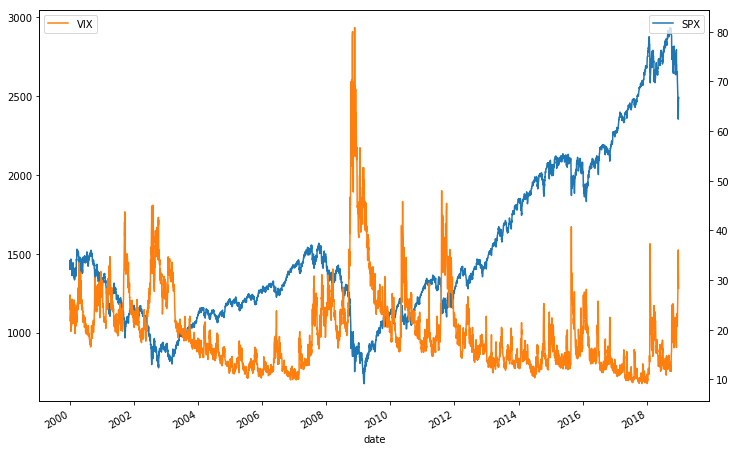

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt # Machine Learning library to create plots and data visualizations

#plotting
plt.figure(figsize = (12, 8))

ax_spx = df['SPX'].plot()
ax_vix = df['VIX'].plot(secondary_y=True)

ax_spx.legend(loc=1)
ax_vix.legend(loc=2)

plt.show();

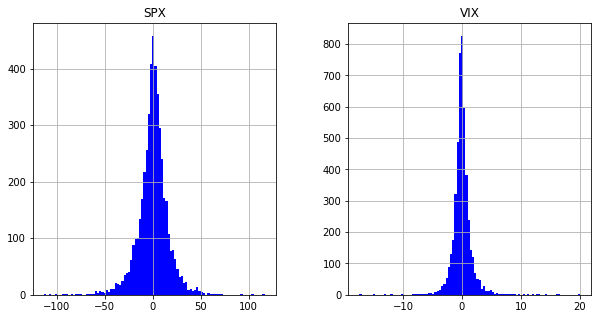

In [12]:
# plotting data by calculating the difference of a DataFrame element compared with another element in the DataFrame.
df.diff().hist(
    figsize=(10, 5),
    color='blue',
    bins=100);

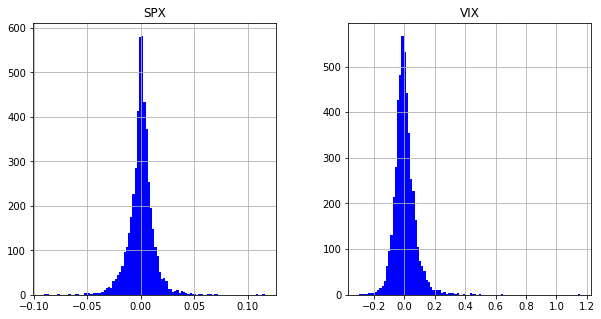

In [13]:
# plotting data by percentage change between the current and a prior element.
df.pct_change().hist(
    figsize=(10, 5),
     color='blue',
     bins=100);

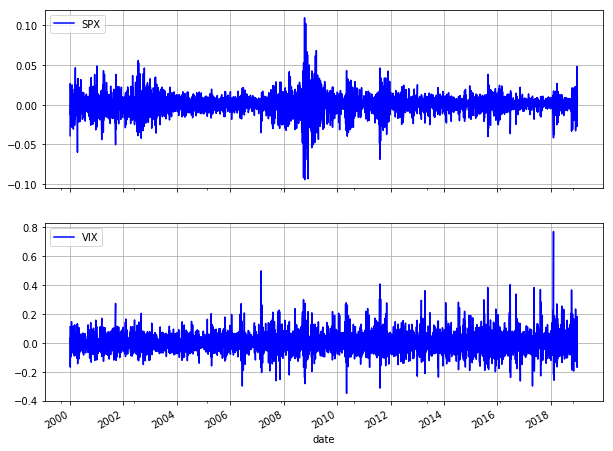

In [14]:
import numpy as np #Numpy provides fast mathematical function processing

log_returns = np.log(df / df.shift(1)).dropna() #logarithmic function

#plotting
log_returns.plot(
    subplots=True,
    figsize=(10, 8),
    color='blue',
    grid=True
);
for ax in plt.gcf().axes:
    ax.legend(loc='upper left')

## Correlation between SPX and VIX

In [18]:
log_returns.corr() #to derive the correlation values between each column of values in the pandas DataFrame object

,SPX,VIX
SPX,1.000000,-0.733786
VIX,-0.733786,1.000000


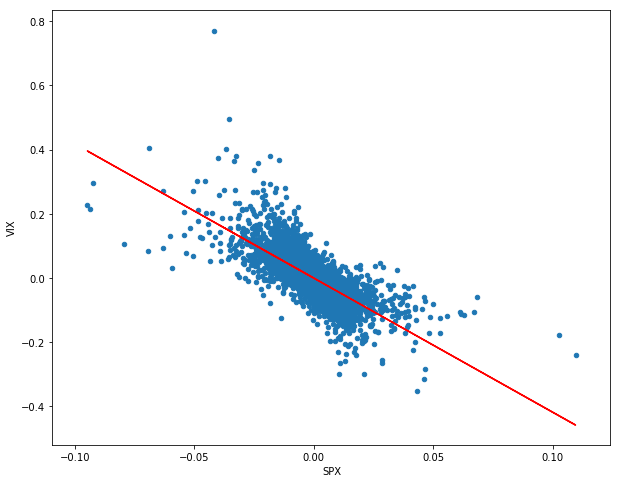

In [19]:
import statsmodels.api as sm # provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration

#plotting
log_returns.plot(
    figsize=(10,8),
     x="SPX",
     y="VIX",
     kind='scatter')

# Fit regression model
ols_fit = sm.OLS(log_returns['VIX'].values, log_returns['SPX'].values).fit()

plt.plot(log_returns['SPX'], ols_fit.fittedvalues, 'r');

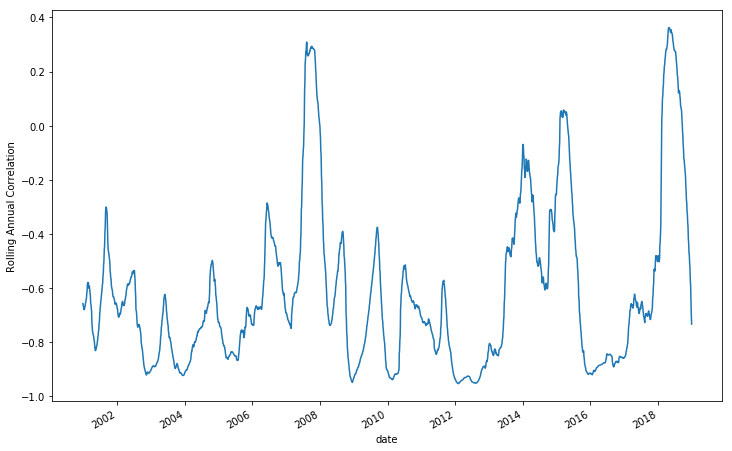

In [20]:
#plotting
plt.ylabel('Rolling Annual Correlation')

df_corr = df['SPX'].rolling(252).corr(other=df['VIX'])
df_corr.plot(figsize=(12,8));

# Calculating the VIX index

In [23]:
import csv #Creates table-like custom objects from the items in a comma-separated value (CSV) file.

META_DATA_ROWS = 3  # Header data starts at line 4
COLS = 7  # Each option data occupy 7 columns

def read_file(filepath):
    meta_rows = []
    calls_and_puts = [] #list for options trading : Calls and Puts

    with open(filepath, 'r') as file: #Opening the file
        reader = csv.reader(file) #Each row read from the csv file is returned as a list of strings.
        for row, cells in enumerate(reader): #differentiating meta data row values and call and put values and storing them in different variables
            if row < META_DATA_ROWS:
                meta_rows.append(cells)  #meta_rows list will have first 4 lines of file
            else:
                call = cells[:COLS]
                put = cells[COLS:-1]

                calls_and_puts.append((call, put)) #                     

    return (meta_rows, calls_and_puts)

In [24]:
(meta_rows, calls_and_puts) = \
    read_file('files/chapter07/SPX_EOD_2018_10_15.csv') #calling the above function to get meta data and call & put separately stored in differet variables

In [25]:
for line in meta_rows: #Printing meta data rows
    print(line)

['SPX (S&P 500 INDEX)', '2750.79', '-16.34']
['Oct 15 2018 @ 20:00 ET']
['Calls', 'Last Sale', 'Net', 'Bid', 'Ask', 'Vol', 'Open Int', 'Puts', 'Last Sale', 'Net', 'Bid', 'Ask', 'Vol', 'Open Int']


In [27]:
from dateutil import parser #This module offers a generic date/time string parser which is able to parse most known formats to represent a date and/or time.

def get_dt_current(meta_rows):
    """
    Extracts time information.

    :param meta_rows: 2D array
    :return: parsed datetime object
    """
    # First cell of second row contains time info
    date_time_row = meta_rows[1][0]

    # Format text as ET time string
    current_time = date_time_row.strip()\
        .replace('@ ', '')\
        .replace('ET', '-05:00')\
        .replace(',', '')

    dt_current =  parser.parse(current_time)#Parse a string in one of the supported formats
    return dt_current

In [28]:
dt_current =  get_dt_current(meta_rows)
print(dt_current)

2018-10-15 20:00:00-05:00


In [29]:
for line in calls_and_puts[:2]:
    print(line) #printing first two call & put values easch having 7 columns

(['2018 Oct 15 1700.00 (SPXW1815J1700)', '0.0', '0.0', '1039.30', '1063.00', '0', '0'], ['2018 Oct 15 1700.00 (SPXW1815V1700)', '0.15', '0.0', ' ', '0.05', '0'])
(['2018 Oct 15 1800.00 (SPXW1815J1800)', '0.0', '0.0', '939.40', '963.00', '0', '0'], ['2018 Oct 15 1800.00 (SPXW1815V1800)', '0.10', '0.0', ' ', '0.05', '0'])


In [30]:
from decimal import Decimal #The decimal module provides support for fast correctly-rounded decimal floating point arithmetic

def parse_expiry_and_strike(text): #to get the expiry date and strike price
    """
    Extracts information about the contract data.

    :param text: the string to parse.
    :return: a tuple of expiry date and strike price
    """
    # SPX Weeklys should expire at 3PM Chicago time.
    [year, month, day, strike, option_code] = text.split(' ') #split(' ') method splits string from a space
    expiry = '%s %s %s 3:00PM -05:00' % (year, month, day)
    dt_object = parser.parse(expiry)    

    """
    Third friday SPX standard options expire at start of trading
    8.30 A.M. Chicago time.
    """
    if is_third_friday(dt_object):
        dt_object = dt_object.replace(hour=8, minute=30)

    strike = Decimal(strike)  #converting strike price to decimal   
    return (dt_object, strike) #returning expiry date and strike price from the text

In [34]:
def is_third_friday(dt_object): #function to check whether the passed date is third friday or not
    return dt_object.weekday() == 4 and 15 <= dt_object.day <= 21

In [32]:
test_contract_code = '2018 Sep 26 1800.00 (*)'
(expiry, strike) = parse_expiry_and_strike(test_contract_code) #Testing our function with a simple contract code data and printing the results:

In [35]:
test_contract_code = '2018 Oct 19 2555.00 (*)'
(expiry, strike) = parse_expiry_and_strike(test_contract_code) #Testing our function for Third Friday

In [37]:
print('Expiry:', expiry)
print('Strike price:', strike)

Expiry: 2018-10-19 08:30:00-05:00
Strike price: 2555.00


In [38]:
#With our utility function in place, we can now go ahead and parse a single call or put option price entry, and return useful information which we can use:
def format_option_data(option_data):
    [desc, _, _, bid_str, ask_str] = option_data[:5]
    bid = Decimal(bid_str.strip() or '0')
    ask = Decimal(ask_str.strip() or '0')
    mid = (bid+ask) / Decimal(2)
    (expiry, strike) = parse_expiry_and_strike(desc)
    return (expiry, strike, bid, ask, mid)

## Finding near-term and next-term options
The VIX Index measures the 30-day expected volatility of the SPX using the market quotes of call and put options expiring between 24 days and 36 days. In between these dates, there will be two SPX option contract maturity dates. Options expiring the nearest are referred to as near-term options, while the options expiring later are referred to as next-term options. Happening once per week, when the option maturities are out of the 24 to 36 days range, new contract maturities will be chosen as the new near-term and next-term options.

In [39]:
CALL_COLS = ['call_bid', 'call_ask', 'call_mid']
PUT_COLS = ['put_bid', 'put_ask', 'put_mid']
COLUMNS = CALL_COLS + PUT_COLS + ['diff']

In [40]:
import pandas as pd

def generate_options_chain(calls_and_puts):
    chain = {} #Instantiating dictionary

    for row in calls_and_puts:
        (call, put) = row
        
        #calling format_option_data to get the useful information
        (call_expiry, call_strike, call_bid, call_ask, call_mid) = \
            format_option_data(call)
        (put_expiry, put_strike, put_bid, put_ask, put_mid) = \
            format_option_data(put)

        # Ensure each line contains the same put and call maturity
        assert(call_expiry == put_expiry)

        # Get or create the DataFrame at the expiry
        df = chain.get(call_expiry, pd.DataFrame(columns=COLUMNS))

        #storing fetched values in dataframe
        df.loc[call_strike, CALL_COLS] = \
            [call_bid, call_ask, call_mid]
        df.loc[call_strike, PUT_COLS] = \
            [put_bid, put_ask, put_mid]
        df.loc[call_strike, 'diff'] = abs(put_mid-call_mid) #The abs() function is used to return the absolute value of a number.

        chain[call_expiry] = df

    return chain

In [41]:
chain = generate_options_chain(calls_and_puts)

In [42]:
#Printing the dictionary keys
chain_keys = list(chain.keys())
for row in chain_keys[:2]:
    print(row)
print('...')
for row in chain_keys[-2:]:
    print(row)

2018-10-15 15:00:00-05:00
2018-10-17 15:00:00-05:00
...
2020-06-19 08:30:00-05:00
2020-12-18 08:30:00-05:00


In [43]:
def find_option_terms(chain, dt_current):
    """
    Find the near-term and next-term dates from
    the given indexes of the dictionary.

    :param chain: dictionary object
    :param dt_current: DateTime object of option quotes
    :return: tuple of 2 datetime objects
    """
    dt_near = None
    dt_next = None

    for dt_object in chain.keys():
        delta = dt_object - dt_current
        if delta.days > 23:
            # Skip non-fridays
            if dt_object.weekday() != 4:
                continue

            # Save the near term date
            if dt_near is None:
                dt_near = dt_object            
                continue

            # Save the next term date
            if dt_next is None:
                dt_next = dt_object            
                break

    return (dt_near, dt_next)

In [44]:
(dt_near, dt_next) = find_option_terms(chain, dt_current)

In [45]:
print('Found near-term maturity', dt_near, 
      'with', dt_near-dt_current, 'to expiry')
print('Found next-term maturity', dt_next, 
      'with', dt_next-dt_current, 'to expiry')

Found near-term maturity 2018-11-09 15:00:00-05:00 with 24 days, 19:00:00 to expiry
Found next-term maturity 2018-11-16 08:30:00-05:00 with 31 days, 12:30:00 to expiry


## Calculating the required minutes
The formula for calculating the VIX is given as follows:
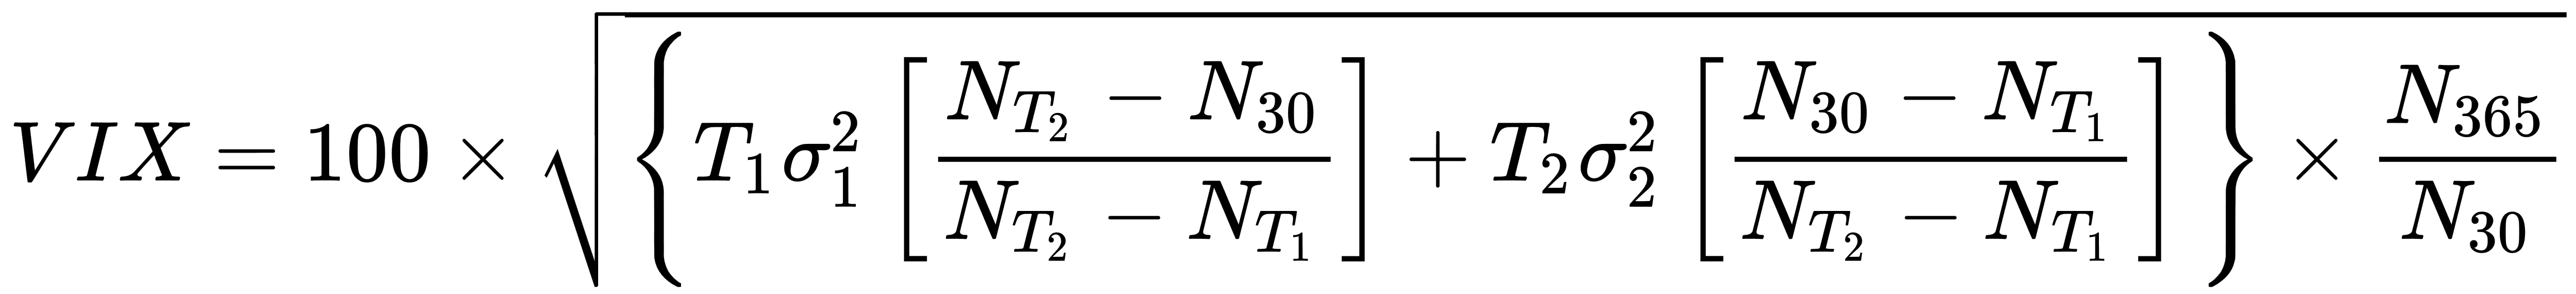

Here, the following applies:

+ T1 is the number of years to settlement of the near-term options
+ T2 is the number of years to settlement of the next-term options
+ NT1 is the number of minutes to settlement of the near-term options
+ NT2 is the number of minutes to settlement of the next-term options
+ N30 is the number of minutes in 30 days
+ N365 is the number of minutes in a year with 365 days

Let's implement in python

In [ ]:
dt_start_year = dt_current.replace(
    month=1, day=1, hour=0, minute=0, second=0)
dt_end_year = dt_start_year.replace(year=dt_current.year+1)

N_t1 = Decimal((dt_near-dt_current).total_seconds() // 60)
N_t2 = Decimal((dt_next-dt_current).total_seconds() // 60)
N_30 = Decimal(30 * 24 * 60)
N_365 = Decimal((dt_end_year-dt_start_year).total_seconds() // 60)

In [48]:
print('N_365:', N_365)
print('N_30:', N_30)
print('N_t1:', N_t1)
print('N_t2:', N_t2)

N_365: 525600
N_30: 43200
N_t1: 35700
N_t2: 45390


In [49]:
t1 = N_t1 / N_365
t2 = N_t2 / N_365

In [50]:
#formatted printing
print('t1:%.5f'%t1)
print('t2:%.5f'%t2)

t1:0.06792
t2:0.08636


## Calculating the forward SPX index level
For each contract month, the forward SPX level F is given as follows:

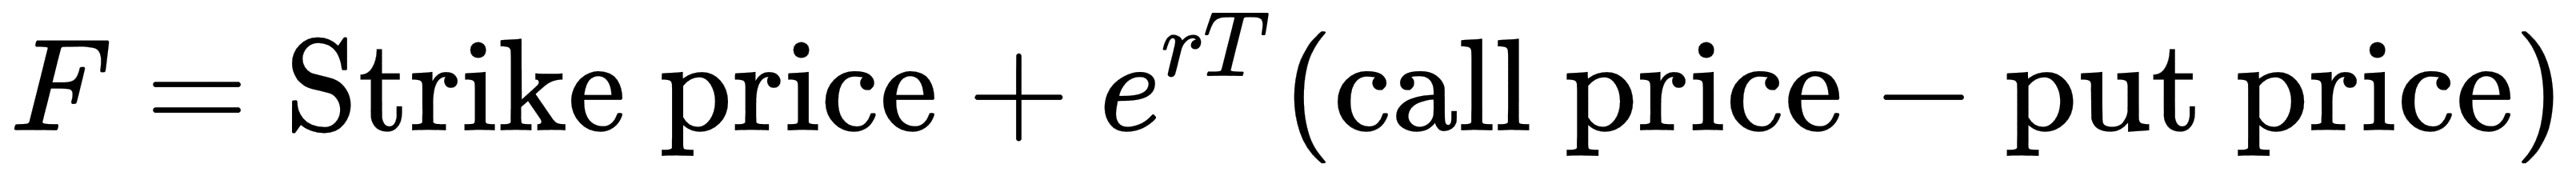

Here, the strike price is chosen where the absolute difference between the call and put prices is the minimum. Note that options with zero bid prices are not taken into account for the VIX Index calculation. This suggests that as volatility of the SPX and options changes, the bid quotes may become zero, and the number of options used in calculation of the VIX Index may vary at any minute!

In [51]:
import math

def determine_forward_level(df, r, t):
    """
    Calculate the forward SPX index level.

    :param df: pandas DataFrame for a single option chain
    :param r: risk-free interest rate for t
    :param t: time to settlement in years
    :return: Decimal object
    """
    min_diff = min(df['diff'])
    pd_k = df[df['diff'] == min_diff]
    k = pd_k.index.values[0]

    call_price = pd_k.loc[k, 'call_mid']
    put_price = pd_k.loc[k, 'put_mid']
    return k + Decimal(math.exp(r*t))*(call_price-put_price)

In [52]:
r = Decimal(2.17/100)

In [53]:
df_near = chain.get(dt_near)
f1 = determine_forward_level(df_near, r, t1)

In [54]:
print('f1:', f1)

f1: 2747.596459994546094129930225


## Finding the required forward strike prices

In [55]:
#The forward strike price is the strike price immediately below the forward SPX level, denoted by k0, 
# and is determined by the find_k0() function, written as follows:
def find_k0(df, f):
    return df[df.index<f].tail(1).index.values[0]

In [56]:
k0_near = find_k0(df_near, f1)

In [57]:
print('k0_near:', k0_near)

k0_near: 2745.00


## Determining strike price boundaries
When selecting options used in the VIX Index calculation, calls and puts with bid prices of zero are ignored. For far out-of-the-money (OTM) put options where strike prices are lower than k0, the lower price boundary terminates when two consecutive zero bid prices are encountered. Similarly, for far OTM call options with strike prices more than k0, the upper price boundary terminates when two consecutive zero bid prices are encountered.

In [60]:
def find_lower_and_upper_bounds(df, k0):
    """
    Find the lower and upper boundry strike prices.

    :param df: the pandas DataFrame of option chain
    :param k0: the forward strike price
    :return: a tuple of two Decimal objects
    """
    # Find lower bound
    otm_puts = df[df.index<k0].filter(['put_bid', 'put_ask'])
    k_lower = 0
    for i, k in enumerate(otm_puts.index[::-1][:-2]):
        k_lower = k
        put_bid_t1 = otm_puts.iloc[-i-1-1]['put_bid']
        put_bid_t2 = otm_puts.iloc[-i-1-2]['put_bid']
        if put_bid_t1 == 0 and put_bid_t2 == 0:
            break
        if put_bid_t2 == 0:
            k_lower = otm_puts.index[-i-1-1]

    # Find upper bound
    otm_calls = df[df.index>k0].filter(['call_bid', 'call_ask'])    
    k_upper = 0
    for i, k in enumerate(otm_calls.index[:-2]):
        call_bid_t1 = otm_calls.iloc[i+1]['call_bid']
        call_bid_t2 = otm_calls.iloc[i+2]['call_bid']
        if call_bid_t1 == 0 and call_bid_t2 == 0:
            k_upper = k
            break

    return (k_lower, k_upper)

In [62]:
(k_lower_near, k_upper_near) = \
    find_lower_and_upper_bounds(df_near, k0_near)

In [63]:
print(k_lower_near, k_upper_near)

1250.00 3040.00


## Tabulating contributions by strike prices
Since the VIX Index is composed of prices of calls and puts options expiring on an average of 30 days, each option of the chosen maturity date contributes to the VIX Index calculation by a certain amount. This amount is given as the general formula:

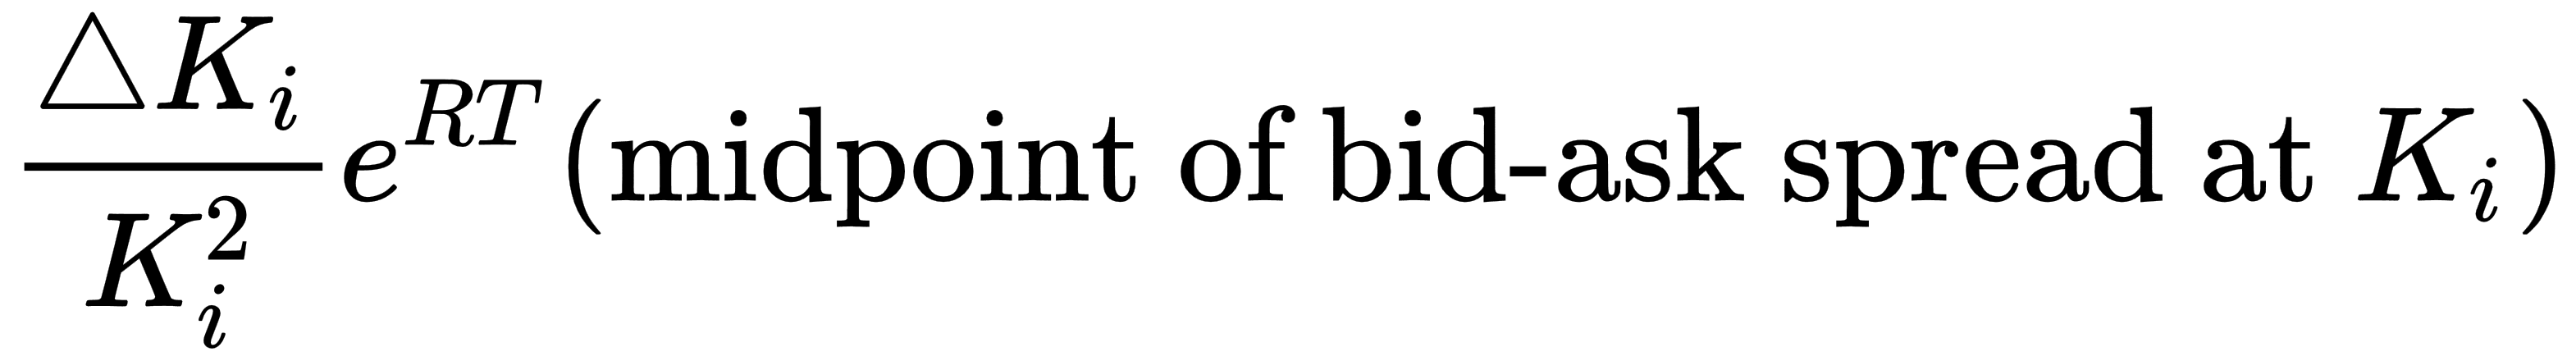

Here, T is the time to expiration of the option, R is the risk-free interest rate to expiration of the option, Ki is the strike price of the ith OTM option, and △Ki is the half-difference on either side of Ki such that △Ki= 0.5(Ki+1-Ki-1).

In [66]:
def calculate_contrib_by_strike(delta_k, k, r, t, q):
    return (delta_k / k**2)*Decimal(math.exp(r*t))*q

In [67]:
def find_prev_k(k, i, k_lower, df, bid_column):
    """
    Finds the strike price immediately below k 
    with non-zero bid.

    :param k: current strike price at i
    :param i: current index of df
    :param k_lower: lower strike price boundary of df
    :param bid_column: The column name that reads the bid price.
        Can be 'put_bid' or 'call_bid'.
    :return: strike price as Decimal object.
    """    
    if k <= k_lower:
        k_prev = df.index[i-1]
        return k_prev

    # Iterate backwards to find put bids           
    k_prev = 0
    prev_bid = 0
    steps = 1
    while prev_bid == 0:                                
        k_prev = df.index[i-steps]
        prev_bid = df.loc[k_prev][bid_column]
        steps += 1

    return k_prev

In [68]:
def find_next_k(k, i, k_upper, df, bid_column):
    """
    Finds the strike price immediately above k 
    with non-zero bid.

    :param k: current strike price at i
    :param i: current index of df
    :param k_upper: upper strike price boundary of df
    :param bid_column: The column name that reads the bid price.
        Can be 'put_bid' or 'call_bid'.
    :return: strike price as Decimal object.
    """    
    if k >= k_upper:
        k_next = df.index[i+1]
        return k_next

    k_next = 0
    next_bid = 0
    steps = 1
    while next_bid == 0:
        k_next = df.index[i+steps]
        next_bid = df.loc[k_next][bid_column]
        steps += 1

    return k_next

In [69]:
import pandas as pd

def tabulate_contrib_by_strike(df, k0, k_lower, k_upper, r, t):
    """
    Computes the contribution to the VIX index
    for every strike price in df.

    :param df: pandas DataFrame containing the option dataset
    :param k0: forward strike price index level
    :param k_lower: lower boundary strike price
    :param k_upper: upper boundary strike price
    :param r: the risk-free interest rate
    :param t: the time to expiry, in years
    :return: new pandas DataFrame with contributions by strike price
    """
    COLUMNS = ['Option Type', 'mid', 'contrib']
    pd_contrib = pd.DataFrame(columns=COLUMNS)

    for i, k in enumerate(df.index):
        mid, bid, bid_column = 0, 0, ''
        if k_lower <= k < k0:
            option_type = 'Put'
            bid_column = 'put_bid'
            mid = df.loc[k]['put_mid']
            bid = df.loc[k][bid_column]
        elif k == k0:
            option_type = 'atm'
        elif k0 < k <= k_upper:
            option_type = 'Call'
            bid_column = 'call_bid'
            mid = df.loc[k]['call_mid']
            bid = df.loc[k][bid_column]
        else:
            continue  # skip out-of-range strike prices

        if bid == 0:
            continue  # skip zero bids

        k_prev = find_prev_k(k, i, k_lower, df, bid_column)
        k_next = find_next_k(k, i, k_upper, df, bid_column)
        delta_k = Decimal((k_next-k_prev)/2)

        contrib = calculate_contrib_by_strike(delta_k, k, r, t, mid)
        pd_contrib.loc[k, COLUMNS] = [option_type, mid, contrib]

    return pd_contrib

In [70]:
pd_contrib_near = tabulate_contrib_by_strike(
    df_near, k0_near, k_lower_near, k_upper_near, r, t1)

In [71]:
pd_contrib_near.head()

,Option Type,mid,contrib
1250.00,Put,0.10,0.000003204720007271874493426366826
1300.00,Put,0.125,0.000003703679742131881579865901010
1350.00,Put,0.15,0.000004121296305647986745661479970
1400.00,Put,0.20,0.000005109566338124799893855814454
1450.00,Put,0.20,0.000004763258036967708819004706934


In [72]:
pd_contrib_near.tail()

,Option Type,mid,contrib
3020.00,Call,0.175,9.608028452572290489411343569E-8
3025.00,Call,0.225,1.231237623174939828257858985E-7
3030.00,Call,0.175,9.544713775211615220689389699E-8
3035.00,Call,0.20,1.087233242345573774601901086E-7
3040.00,Call,0.15,8.127448187590304540304760266E-8


## Calculating the volatilities
The volatility calculation for the chosen options is given as follows:

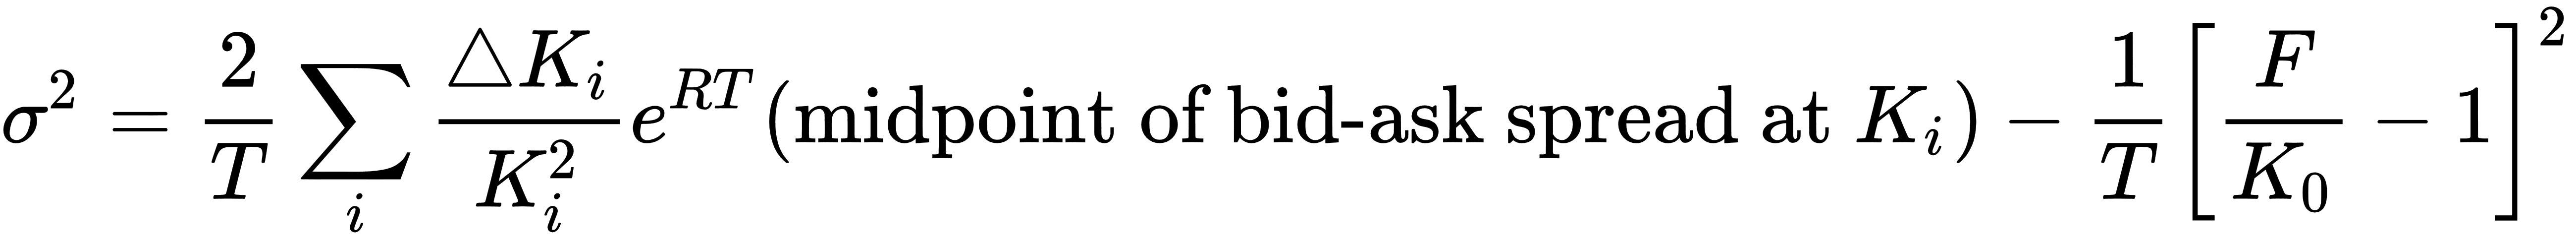

Since we have already computed the contributions for the summation term, this formula can be simply written in Python as the calculate_volatility() function:

In [73]:
def calculate_volatility(pd_contrib, t, f, k0):
    """
    Calculate the volatility for a single-term option

    :param pd_contrib: pandas DataFrame containing 
        contributions by strike
    :param t: time to settlement of the option
    :param f: forward index level
    :param k0: immediate strike price below the forward level
    :return: volatility as Decimal object
    """
    term_1 = Decimal(2/t)*pd_contrib['contrib'].sum()
    term_2 = Decimal(1/t)*(f/k0 - 1)**2
    return term_1 - term_2

In [75]:
volatility_near = calculate_volatility(
    pd_contrib_near, t1, f1, k0_near)

In [76]:
print('volatility_near:', volatility_near)

volatility_near: 0.04891704334249740486501736967


## Calculating the next-term options

In [78]:
#Just as we did for near-term options, calculating the next-term options is pretty straightforward with the following Python calls to the functions already defined in place:
df_next = chain.get(dt_next)

f2 = determine_forward_level(df_next, r, t2)
k0_next = find_k0(df_next, f2)
(k_lower_next, k_upper_next) = \
    find_lower_and_upper_bounds(df_next, k0_next)
pd_contrib_next = tabulate_contrib_by_strike(
    df_next, k0_next, k_lower_next, k_upper_next, r, t2)
volatility_next = calculate_volatility(
    pd_contrib_next, t2, f2, k0_next)

## Calculating the VIX index
Finally, the 30-day weighted average of the VIX Index is written as follows:

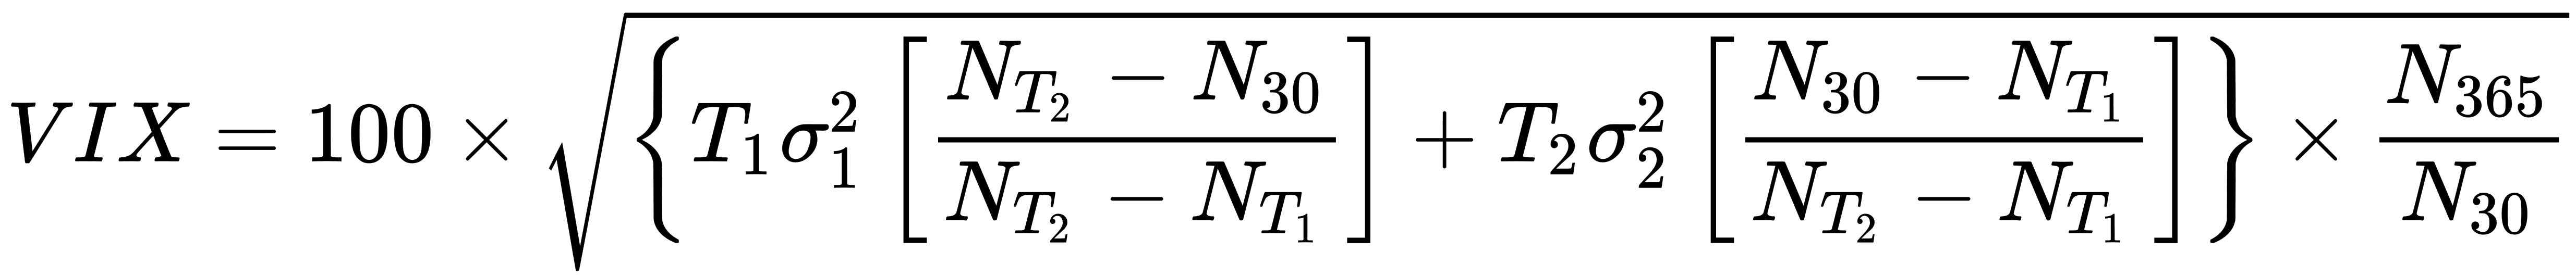

In [79]:
#Representing this formula in Python code gives us the following:
def calculate_vix_index(t1, volatility_1, t2, 
                        volatility_2, N_t1, N_t2, N_30, N_365):
    inner_term_1 = t1*Decimal(volatility_1)*(N_t2-N_30)/(N_t2-N_t1)
    inner_term_2 = t2*Decimal(volatility_2)*(N_30-N_t1)/(N_t2-N_t1)
    sqrt_terms = math.sqrt((inner_term_1+inner_term_2)*N_365/N_30)
    return 100 * sqrt_terms

In [80]:
# Substituting with the values from near-term and next-term options provides the following:
vix = calculate_vix_index(
    t1, volatility_near, t2, 
    volatility_next, N_t1, N_t2, 
    N_30, N_365)

In [81]:
print('At', dt_current, 'the VIX is', vix)

At 2018-10-15 20:00:00-05:00 the VIX is 21.431114075693934


## Calculating multiple VIX indexes
With a single VIX value calculated for a particular trading day, we can reuse the defined functions to calculate VIX values over a time period.

Let's write a function, process_file(), to process a single file path, and return the calculated VIX Index:

In [82]:
    def process_file(filepath):
        """
        Reads the filepath and calculates the VIX index.

        :param filepath: path the options chain file
        :return: VIX index value
        """
        headers, calls_and_puts = read_file(filepath)    
        dt_current = get_dt_current(headers)

        chain = generate_options_chain(calls_and_puts)
        (dt_near, dt_next) = find_option_terms(chain, dt_current)

        N_t1 = Decimal((dt_near-dt_current).total_seconds() // 60)
        N_t2 = Decimal((dt_next-dt_current).total_seconds() // 60)
        t1 = N_t1 / N_365
        t2 = N_t2 / N_365

        # Process near-term options
        df_near = chain.get(dt_near)
        f1 = determine_forward_level(df_near, r, t1)
        k0_near = find_k0(df_near, f1)
        (k_lower_near, k_upper_near) = find_lower_and_upper_bounds(
            df_near, k0_near)
        pd_contrib_near = tabulate_contrib_by_strike(
            df_near, k0_near, k_lower_near, k_upper_near, r, t1)
        volatility_near = calculate_volatility(
            pd_contrib_near, t1, f1, k0_near)

        # Process next-term options
        df_next = chain.get(dt_next)
        f2 = determine_forward_level(df_next, r, t2)
        k0_next = find_k0(df_next, f2)
        (k_lower_next, k_upper_next) = find_lower_and_upper_bounds(
            df_next, k0_next)
        pd_contrib_next = tabulate_contrib_by_strike(
            df_next, k0_next, k_lower_next, k_upper_next, r, t2)
        volatility_next = calculate_volatility(
            pd_contrib_next, t2, f2, k0_next)

        vix = calculate_vix_index(
            t1, volatility_near, t2, 
            volatility_next, N_t1, N_t2, 
            N_30, N_365)

        return vix

In [83]:
FILE_DATES = [
    '2018_10_15',
    '2018_10_16',
    '2018_10_17',
    '2018_10_18',
    '2018_10_19',
]
FILE_PATH_PATTERN = 'files/chapter07/SPX_EOD_%s.csv'

In [84]:
pd_calcs = pd.DataFrame(columns=['VIX'])

for file_date in FILE_DATES:
    filepath = FILE_PATH_PATTERN % file_date

    vix = process_file(filepath)    
    date_obj = parser.parse(file_date.replace('_', '-'))

    pd_calcs.loc[date_obj, 'VIX'] = vix

In [85]:
pd_calcs.head(5)

,VIX
2018-10-15,21.4311
2018-10-16,17.7384
2018-10-17,17.4741
2018-10-18,20.0477
2018-10-19,19.9196


## Comparing the results

In [87]:
# Let's compare the calculated VIX values against actual VIX values by reusing the DataFrame df_vix_data VIX Index
# that was downloaded in an earlier section, and extract only the relevant values for the corresponding week
#of 15th to 19th of October, 2018:
df_vix = df_vix_data['2018-10-14':'2018-10-21']['5. adjusted close']

In [88]:
df_vix.head(5)

date
2018-10-15    21.30
2018-10-16    17.62
2018-10-17    17.40
2018-10-18    20.06
2018-10-19    19.89
Name: 5. adjusted close, dtype: float64

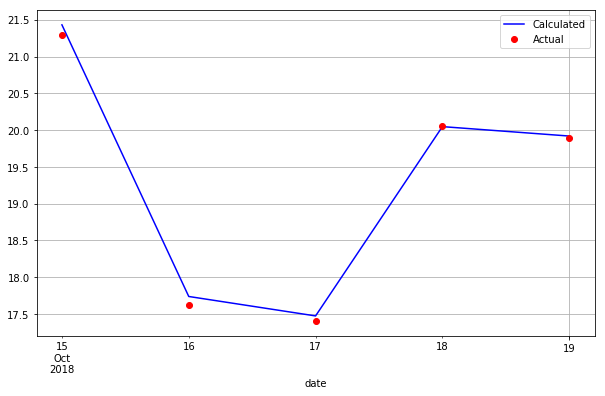

In [89]:
#plotting
df_merged = pd.DataFrame({
    'Calculated': pd_calcs['VIX'],
    'Actual': df_vix,
})
df_merged.plot(figsize=(10, 6), grid=True, style=['b', 'ro']);